In [1]:
import tensorflow as tf
import json
import numpy as np

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [6]:
train_images.as_numpy_iterator().next()

array([[[0.35128677, 0.19742647, 0.2694853 ],
        [0.39136028, 0.21397059, 0.30447304],
        [0.38860294, 0.21109068, 0.2726103 ],
        ...,
        [0.7821691 , 0.66629905, 0.8584559 ],
        [0.7844363 , 0.66335785, 0.84681374],
        [0.794424  , 0.66795343, 0.8625613 ]],

       [[0.4028799 , 0.24993873, 0.32181373],
        [0.44105393, 0.28909314, 0.36997548],
        [0.39123774, 0.25704658, 0.32414216],
        ...,
        [0.7716299 , 0.6706495 , 0.8598652 ],
        [0.78272057, 0.67340684, 0.86311275],
        [0.7893995 , 0.6764706 , 0.8526348 ]],

       [[0.5158088 , 0.3658701 , 0.41752452],
        [0.5088235 , 0.36862746, 0.41764706],
        [0.5530025 , 0.42751226, 0.4786152 ],
        ...,
        [0.79105395, 0.69693625, 0.88615197],
        [0.7882966 , 0.6858456 , 0.87555146],
        [0.7703431 , 0.66838235, 0.85631126]],

       ...,

       [[0.4126838 , 0.31740198, 0.43474266],
        [0.37904412, 0.28884804, 0.39178923],
        [0.35931373, 0

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [8]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [9]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2246, 0.2424, 0.605 , 0.6855], dtype=float16))

In [10]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(1200)
train = train.batch(64)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(3400)
test = test.batch(64)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(7000)
val = val.batch(64)
val = val.prefetch(4)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [12]:
vgg = VGG16(include_top=False) #for image classicification

In [13]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [14]:
def build_model():
  input_layer = Input(shape=(120,120,3))

  vgg = VGG16(include_top=False)(input_layer)

  #classification
  pc1 = GlobalMaxPooling2D()(vgg)
  dc1 = Dense(2048,activation='relu')(pc1)
  dc2 = Dense(1,activation='sigmoid')(dc1)

  #regression for bounding box
  pr1 = GlobalMaxPooling2D()(vgg)
  dr1 = Dense(2048,activation='relu')(pr1)
  dr2 = Dense(4,activation='sigmoid')(dr1)

  face_tracker = Model(inputs=input_layer, outputs = [dc2,dr2])

  return face_tracker

In [15]:
face_tracker = build_model()

In [16]:
face_tracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [17]:
#define losses and optimizer
batch_per_epoch = len(train)
lr_decay = (1./.75 - 1)/batch_per_epoch

In [18]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,decay=lr_decay)

In [19]:
#object detection loss function YOLO

def localization_loss(y_true,yhat):
  delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

  h_true = y_true[:,3] - y_true[:,1]
  w_true = y_true[:,2] - y_true[:,0]

  h_pred = yhat[:,3] - yhat[:,1]
  w_pred = yhat[:,2] - yhat[:,0]

  delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

  return delta_coord + delta_size

In [20]:
clsfn_loss = tf.keras.losses.BinaryCrossentropy()
rgrsn_loss = localization_loss

In [21]:
class FaceDetector(Model):
  def __init__(self,tracker,**kwargs):
    super().__init__(**kwargs)
    self.model = tracker

  def compile(self, opt, classloss, locloss, **kwargs):
    super().compile(**kwargs)
    self.opt = opt
    self.closs = classloss
    self.lloss = locloss

  def train_step(self, batch, **kwargs):
    x,y = batch

    with tf.GradientTape() as tape:
      classes, coords = self.model(x,training=True)

      batch_closs = self.closs(y[0],classes)
      batch_lloss = self.lloss(tf.cast(y[1],tf.float32),coords)

      batch_loss = batch_lloss + batch_closs*0.5

      grad = tape.gradient(batch_loss, self.model.trainable_variables)

    opt.apply_gradients(zip(grad,self.model.trainable_variables))

    return {"total_loss": batch_loss, "class_loss": batch_closs, "regress_loss": batch_lloss}

  def test_step(self, batch, **kwargs):
    x,y = batch

    classes, coords = self.model(x,training=True)

    batch_closs = self.closs(y[0],classes)
    batch_lloss = self.lloss(tf.cast(y[1],tf.float32),coords)

    batch_loss = batch_lloss + batch_closs*0.5

    return {"total_loss": batch_loss, "class_loss": batch_closs, "regress_loss": batch_lloss}

  def call(self, **kwargs):
    return self.model(x,**kwargs)

In [22]:
model = FaceDetector(face_tracker)

In [23]:
model.compile(opt,clsfn_loss,rgrsn_loss)

In [24]:
hist = model.fit(train, epochs = 20, validation_data = val)

Epoch 1/20
57/57 [==============================] - 50s 521ms/step - total_loss: 6.7960 - class_loss: 0.3358 - regress_loss: 6.6281 - val_total_loss: 0.2890 - val_class_loss: 0.1909 - val_regress_loss: 0.1935
Epoch 2/20
57/57 [==============================] - 24s 399ms/step - total_loss: 1.6302 - class_loss: 0.1028 - regress_loss: 1.5788 - val_total_loss: 1.1746 - val_class_loss: 0.7791 - val_regress_loss: 0.7851
Epoch 3/20
57/57 [==============================] - 24s 405ms/step - total_loss: 0.8693 - class_loss: 0.0473 - regress_loss: 0.8456 - val_total_loss: 0.2466 - val_class_loss: 0.1272 - val_regress_loss: 0.1830
Epoch 4/20
57/57 [==============================] - 25s 422ms/step - total_loss: 0.5313 - class_loss: 0.0234 - regress_loss: 0.5196 - val_total_loss: 2.7426 - val_class_loss: 0.9351 - val_regress_loss: 2.2750
Epoch 5/20
57/57 [==============================] - 25s 420ms/step - total_loss: 0.4095 - class_loss: 0.0165 - regress_loss: 0.4013 - val_total_loss: 0.2996 - val_c

In [25]:
from tensorflow.keras.models import load_model
face_tracker.save('face_det.h5')

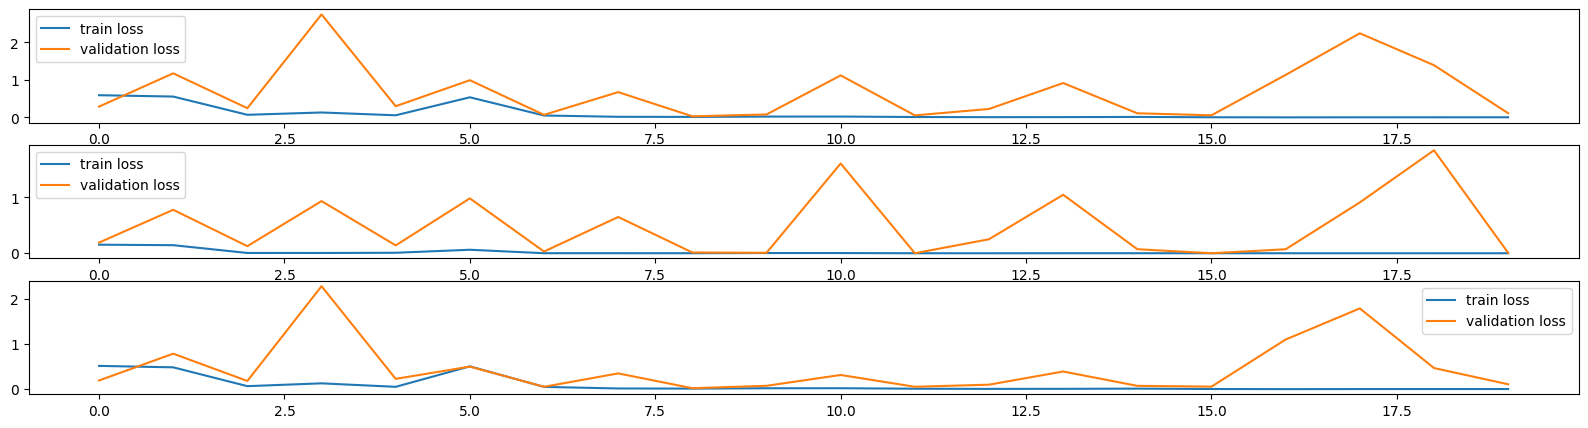

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'],label='train loss')
ax[0].plot(hist.history['val_total_loss'],label='validation loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'],label='train loss')
ax[1].plot(hist.history['val_class_loss'],label='validation loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'],label='train loss')
ax[2].plot(hist.history['val_regress_loss'],label='validation loss')
ax[2].legend()

plt.show()